In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7142548.datarmor0/parcels-502090/libparcels_random_6bb4e898-0f19-4f40-876f-76c69b43b51d.so


In [2]:
from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors



In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=4
                 )
#
client = Client(cluster)

In [4]:
isel = dict(face=7)
sel = dict(i=slice(2900,3100), j=slice(2900,3100))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
#sel = dict(i=[3000,3010], j=[3000,3010], i_g=[3000,3010], j_g=[3000,3010]) # North East Hawaii

In [5]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [6]:
ds = ut.load_data(["SSU", "SSV"])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

In [7]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})#.drop(['i_g','j_g'])
#dsi = ds#.isel(time=slice(0*24,100*24))

In [8]:
import mitequinox.plot as pl
import mitequinox.sigp as sp

In [9]:
#points = dict(south_atlantic=[7, 3000, 3000],
#              north_pacific=[7, 3050, 3050],
#             )
#_d = xr.DataArray(list(points),dims="point", name="point")
# the line below might be very inefficient
#dsp = xr.concat([dsi.isel(face=i[0], i=i[1], i_g=i[1], j=int(i[2]),j_g=int(i[2])) 
#                 for p, i in points.items()], 
#                dim=_d,
#               )

#dsi['zonal_velocity'] = dsi['SSU']*dsi.CS - dsi['SSV']*dsi.SN
#dsi['meridional_velocity'] =  dsi['SSU']*dsi.SN + dsi['SSV']*dsi.CS
dsp = ds.isel(**isel).sel(**sel)

dsp = dsp.chunk({"time": -1,"i":50,"j":50}).persist()
dsp

<xarray.Dataset>
Dimensions:  (i: 201, j: 201, time: 8785)
Coordinates:
    face     int64 7
  * j        (j) int64 2900 2901 2902 2903 2904 ... 3096 3097 3098 3099 3100
    niter    (time) int64 dask.array<chunksize=(8785,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * i        (i) int64 2900 2901 2902 2903 2904 ... 3096 3097 3098 3099 3100
    XC       (j, i) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables:
    SSU      (time, j, i) float32 dask.array<chunksize=(8785, 50, 50), meta=np.ndarray>
    SSV      (time, j, i) float32 dask.array<chunksize=(8785, 50, 50), meta=np.ndarray>
    lon      (j, i) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    lat      (j, i) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [10]:
dsp['zonal_velocity'] = dsp['SSU']*dsp.CS - dsp['SSV']*dsp.SN
dsp['meridional_velocity'] =  dsp['SSU']*dsp.SN + dsp['SSV']*dsp.CS
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat})
dsp = dsp.drop(['SSU','SSV']).persist()


In [11]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .2, "semidiurnal"

h = sp.generate_filter(omega, T=10, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


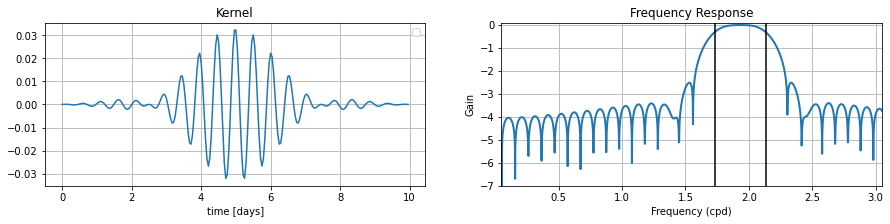

In [12]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-domega, color='k')
ax.axvline(omega+domega, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

#### Band passed (no Hilbert transform)

In [13]:
for v in ['zonal_velocity','meridional_velocity']:
    dsp[v+"_hat"] = filt(dsp[v], h,hilbert=False
                        )
dsp = dsp.persist()

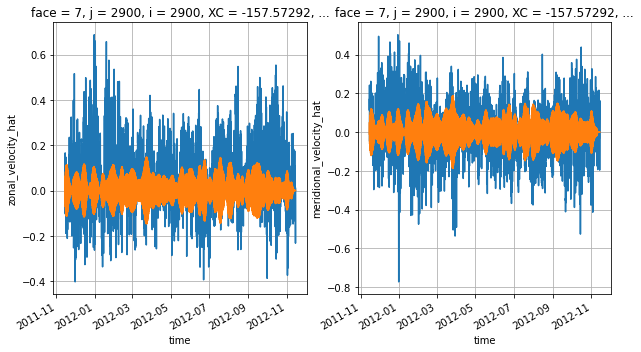

In [14]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    dsp[v].isel(i=0,j=0).plot(ax=ax)
    dsp[v+'_hat'].isel(i=0,j=0).plot(ax=ax)
    ax.grid()

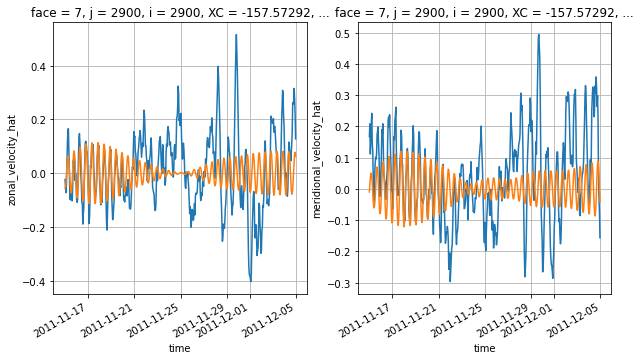

In [15]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    dsp[v].isel(i=0,j=0).isel(time=slice(0,20*24)).plot(ax=ax)
    dsp[v+'_hat'].isel(i=0,j=0).isel(time=slice(0,20*24)).plot(ax=ax)
    ax.grid()

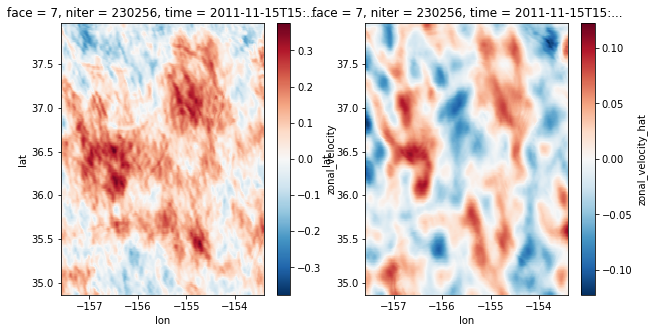

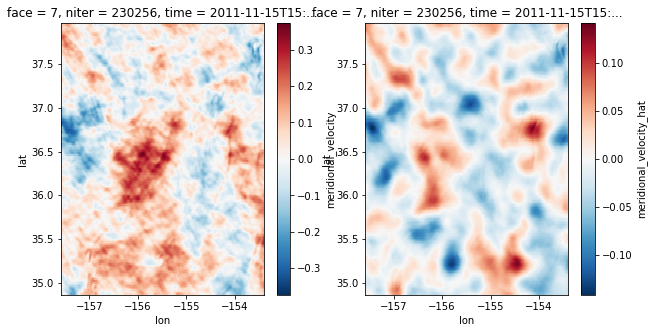

In [21]:
it = 15
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    dsp[v+'_hat'].isel(time=it).plot(ax=ax[1],x='lon',y='lat')
    dsp[v].isel(time=it).plot(ax=ax[0],x='lon',y='lat')#,x='lon',y='lat'

#### With Hilbert transform
(ajouter formules)

In [22]:
for v in ['zonal_velocity','meridional_velocity']:
    dsp[v+"_hat"] = filt(dsp[v], h,hilbert=True
                        )

In [23]:
dsp = dsp.assign_coords({'lon':dsp.lon,'lat':dsp.lat})
dsp = dsp.persist()

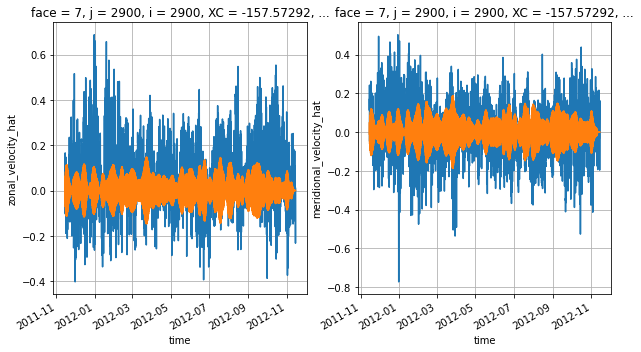

In [24]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    dsp[v].isel(i=0,j=0).plot(ax=ax)
    np.real(dsp[v+'_hat']).isel(i=0,j=0).plot(ax=ax)
    ax.grid()

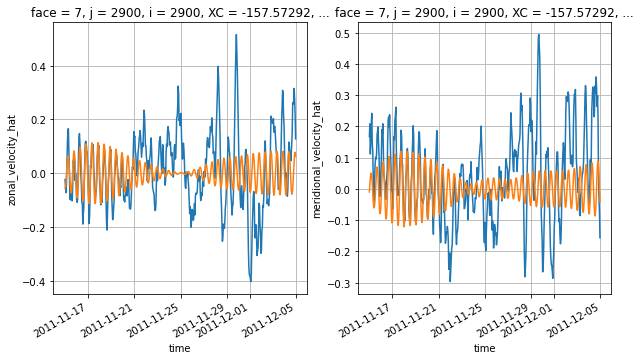

In [25]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    dsp[v].isel(i=0,j=0).isel(time=slice(0,20*24)).plot(ax=ax)
    np.real(dsp[v+'_hat']).isel(time=slice(0,20*24)).isel(i=0,j=0).plot(ax=ax)
    ax.grid()

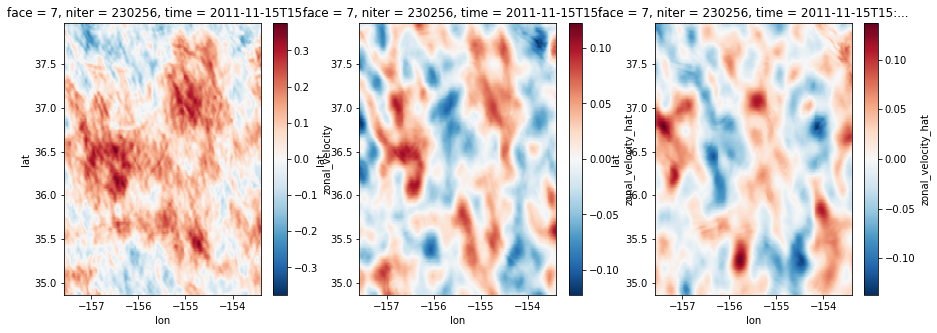

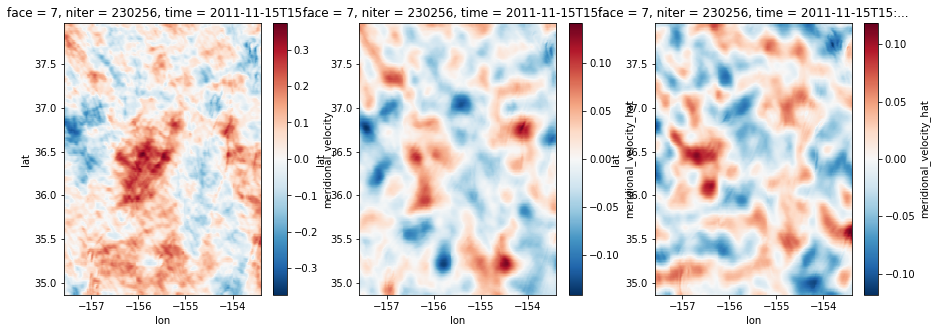

In [26]:
it = 15
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    np.real(dsp[v+'_hat']).isel(time=it).plot(ax=ax[1],x='lon',y='lat')
    np.imag(dsp[v+'_hat']).isel(time=it).plot(ax=ax[2],x='lon',y='lat')
    dsp[v].isel(time=it).plot(ax=ax[0],x='lon',y='lat')#,x='lon',y='lat'

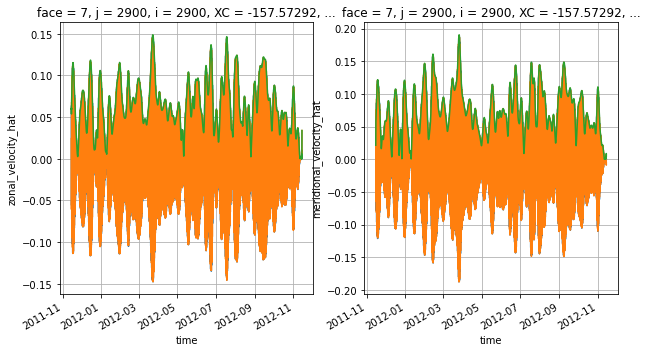

In [27]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    #dsp[v].isel(i=0,j=0).plot(ax=ax)
    np.real(dsp[v+'_hat']).isel(i=0,j=0).plot(ax=ax)
    np.imag(dsp[v+'_hat']).isel(i=0,j=0).plot(ax=ax)
    np.abs(dsp[v+'_hat']).isel(i=0,j=0).plot(ax=ax)
    ax.grid()

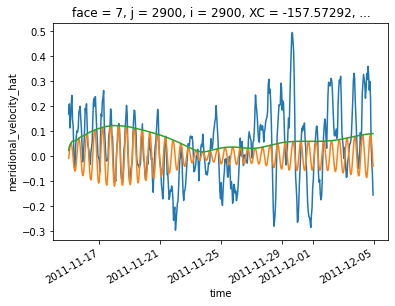

In [28]:
dsp[v].isel(time=slice(24*0,24*20),i=0,j=0).plot()
np.real(dsp[v+'_hat']).isel(time=slice(24*0,24*20),i=0,j=0).plot()
np.abs(dsp[v+'_hat']).isel(time=slice(24*0,24*20),i=0,j=0).plot()

### Definition of filters with different time window sizes and bandwidth

In [21]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .2, "semidiurnal"
T_window,bandwidths = [10,20,30],[0.1,0.2,0.3,0.4]

In [22]:
H = xr.combine_nested([[xr.DataArray(sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None),
             dims=['time'],coords={'time':np.arange(0,sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None).size)*dt}) for T in T_window
                       ] for dband in bandwidths],concat_dim=['bandwidth','T_window'])
                     # coords={'time':np.arange(0,sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None).size)*dt,'T_window':T_window,'bandwidth':bandwidths})

H = H.assign_coords({'T_window':T_window,'bandwidth':bandwidths})
H
#xr.concat([xr.DataArraysp.generate_filter(omega, T=T, dt=dt, bandwidth=domega, normalized_bandwidth=None) for T in [10,20,30]],dim='T_window')

<xarray.DataArray (T_window: 3, bandwidth: 4, time: 720)>
array([[[-4.79577095e-06, -1.94207612e-05, -3.28593800e-05, ...,
                     nan,             nan,             nan],
        [ 8.04766936e-06,  3.25671830e-05,  5.50271995e-05, ...,
                     nan,             nan,             nan],
        [-1.20939217e-05, -4.88855777e-05, -8.24106337e-05, ...,
                     nan,             nan,             nan],
        [ 1.61943560e-05,  6.53554406e-05,  1.09821756e-04, ...,
                     nan,             nan,             nan]],

       [[ 5.61926911e-07, -2.48335914e-06, -1.01159979e-05, ...,
                     nan,             nan,             nan],
        [ 1.13105376e-06, -4.99511167e-06, -2.03197566e-05, ...,
                     nan,             nan,             nan],
        [ 1.69582901e-06, -7.48079141e-06, -3.03617031e-05, ...,
                     nan,             nan,             nan],
        [ 2.25971183e-06, -9.95228970e-06, -4.02629625e-05, ...,
                     nan,             nan,             nan]],

       [[ 1.73690142e-06,  3.63845117e-06,  1.90621384e-06, ...,
          1.90621384e-06,  3.63845117e-06,  1.73690142e-06],
        [-3.48786449e-06, -7.30135118e-06, -3.81999158e-06, ...,
         -3.81999158e-06, -7.30135118e-06, -3.48786449e-06],
        [ 5.21062466e-06,  1.08952439e-05,  5.68723806e-06, ...,
          5.68723806e-06,  1.08952439e-05,  5.21062466e-06],
        [-6.96657159e-06, -1.45435602e-05, -7.56727158e-06, ...,
         -7.56727158e-06, -1.45435602e-05, -6.96657159e-06]]])
Coordinates:
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 29.88 29.92 29.96
  * T_window   (T_window) int64 10 20 30
  * bandwidth  (bandwidth) float64 0.1 0.2 0.3 0.4

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


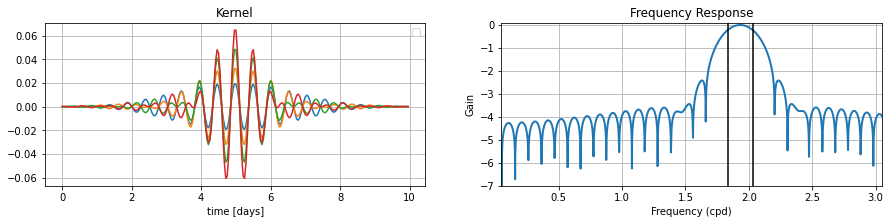

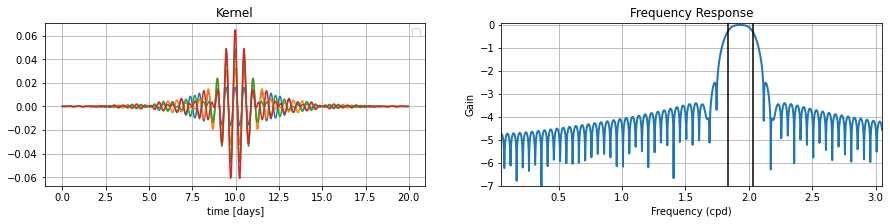

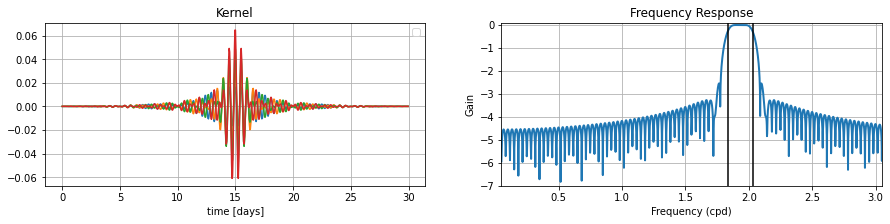

In [23]:
domega=0.1
for h in H.T_window:
    h_hat, w = sp.filter_response(H.sel(T_window=h,bandwidth=0.1).dropna(dim='time'), dt=dt)
    fig, axes = plt.subplots(1,2, figsize=(15,3))
    ax = axes[0]
    #t = np.arange(0, h.size)*dt
    H.sel(T_window=h).plot(ax=ax,hue='bandwidth')
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')
    ax.legend()

    ax = axes[1]
    ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
    ax.axvline(omega-domega, color='k')
    ax.axvline(omega+domega, color='k')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(0.05, 3.05)
    ax.grid(True)
    #H.plot.line(hue='T_window')

In [24]:
ds_hat={}
for v in ['zonal_velocity','meridional_velocity']:
    ds_hat[v+'_hat'] = xr.combine_nested([[filt(dsp[v], H.sel(T_window=h,bandwidth=dband).dropna(dim='time'),hilbert=True) for h in H.T_window]for dband in H.bandwidth]
                                 ,concat_dim=['bandwidth','T_window']).persist()
    ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'T_window':T_window,'bandwidth':bandwidths})

In [25]:
for v in ['zonal_velocity','meridional_velocity']:
    ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})

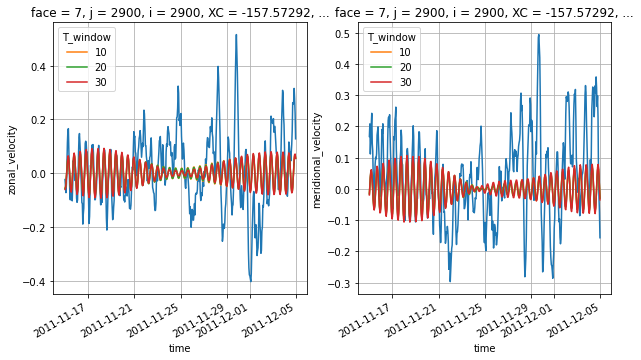

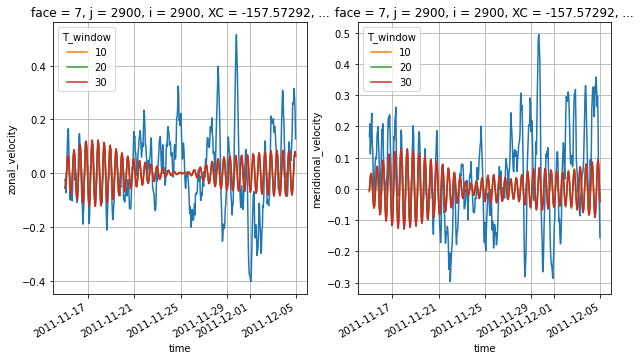

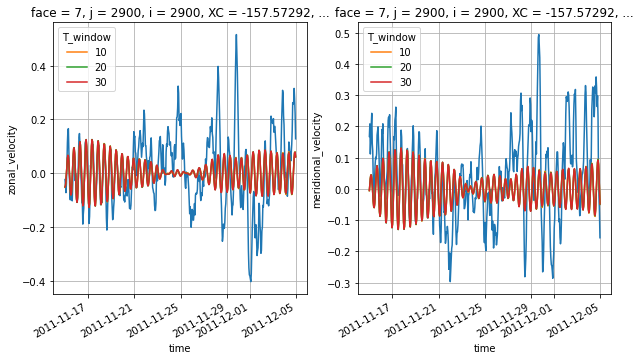

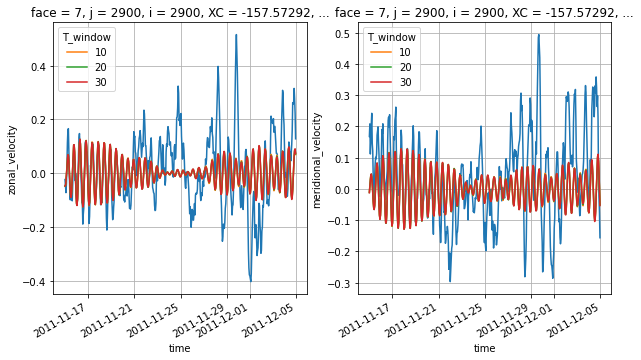

In [26]:
for dband in H.bandwidth:
    fig,axs = plt.subplots(1,2,figsize=(10,5))
    for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
        dsp[v].isel(i=0,j=0).isel(time=slice(0,20*24)).plot(ax=ax)
        np.real(ds_hat[v+'_hat']).isel(time=slice(0,20*24)).isel(i=0,j=0).sel(bandwidth=dband).plot(ax=ax,hue='T_window')
        ax.grid()

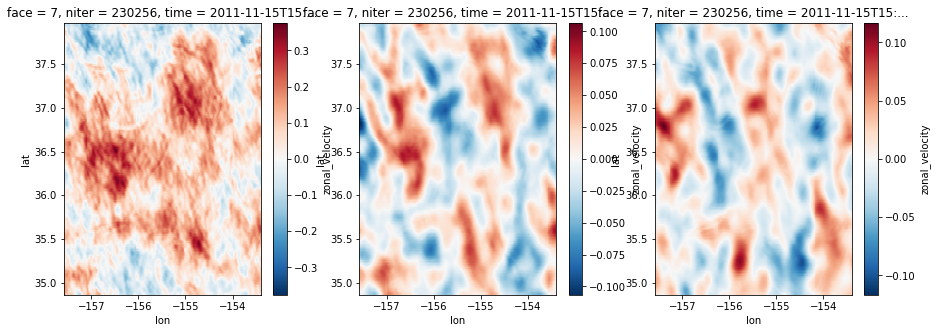

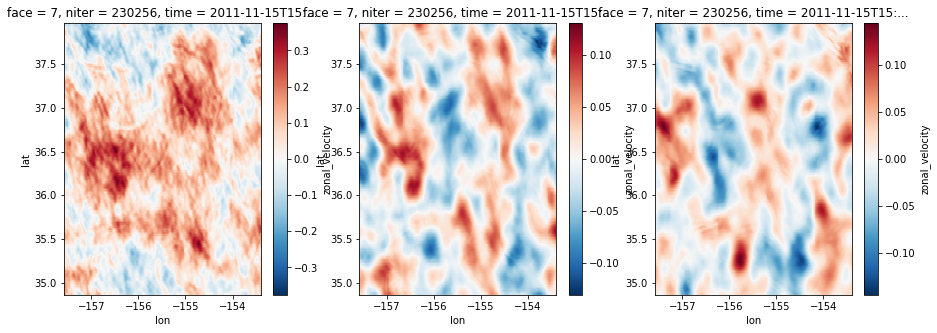

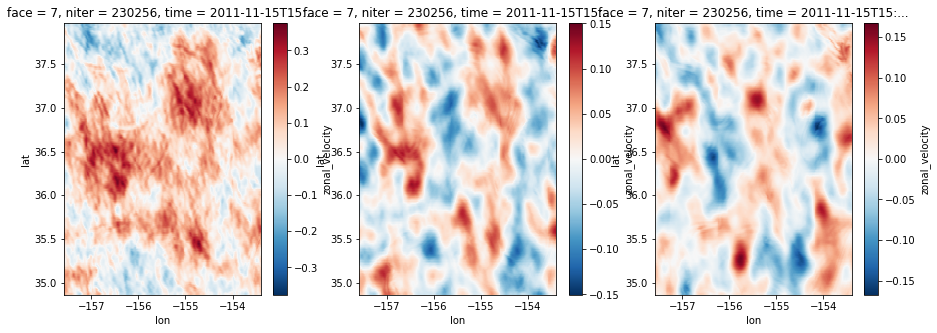

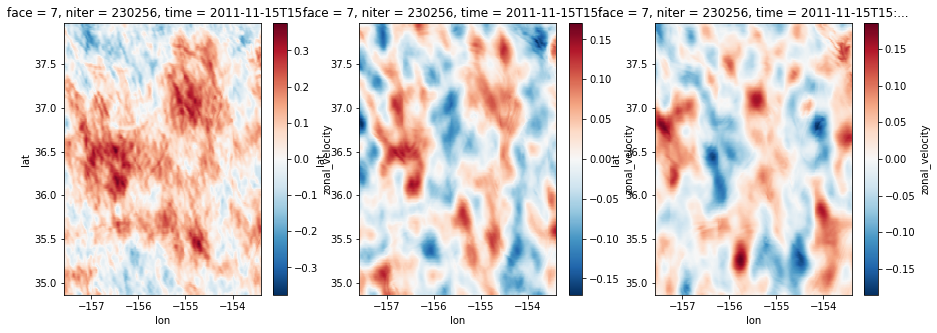

In [27]:
it = 15
v='zonal_velocity'
for dband in H.bandwidth:
    #for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    np.real(ds_hat[v+'_hat']).isel(time=it,T_window=1).sel(bandwidth=dband).plot(ax=ax[1],x='lon',y='lat')
    np.imag(ds_hat[v+'_hat']).isel(time=it,T_window=1).sel(bandwidth=dband).plot(ax=ax[2],x='lon',y='lat')
    dsp[v].isel(time=it).plot(ax=ax[0],x='lon',y='lat')#,x='lon',y='lat'

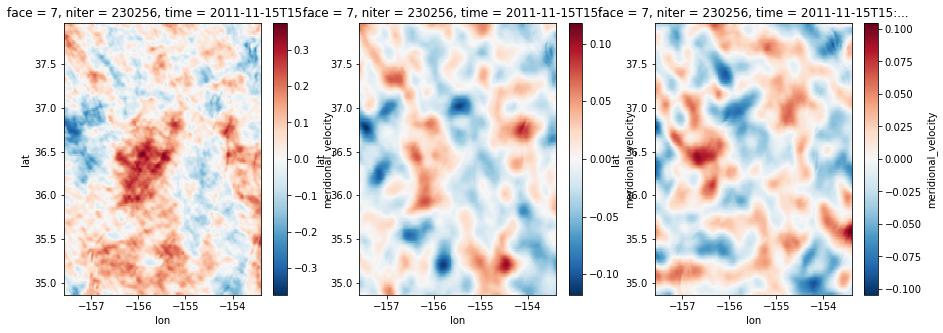

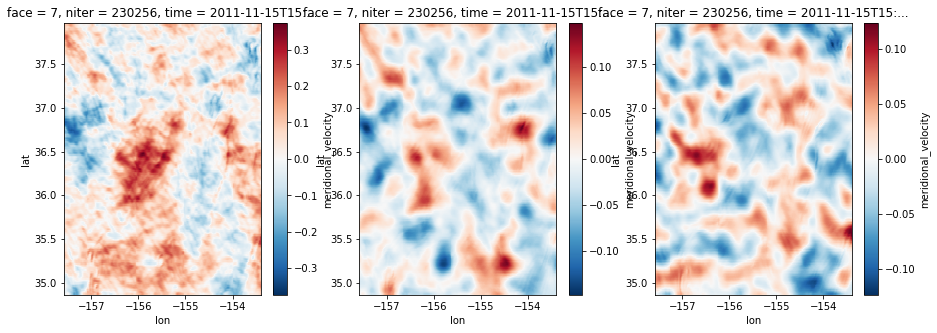

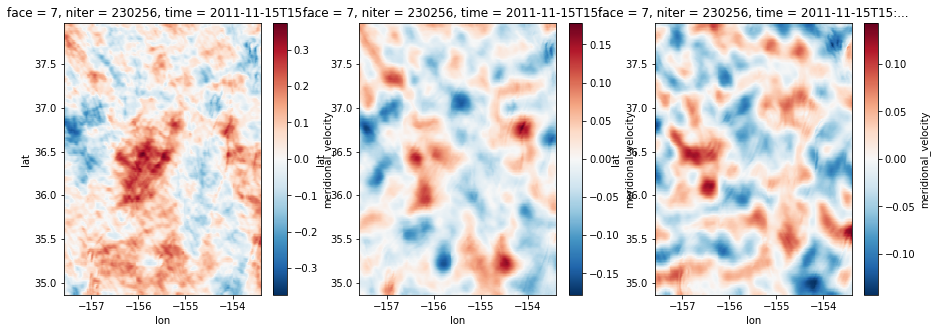

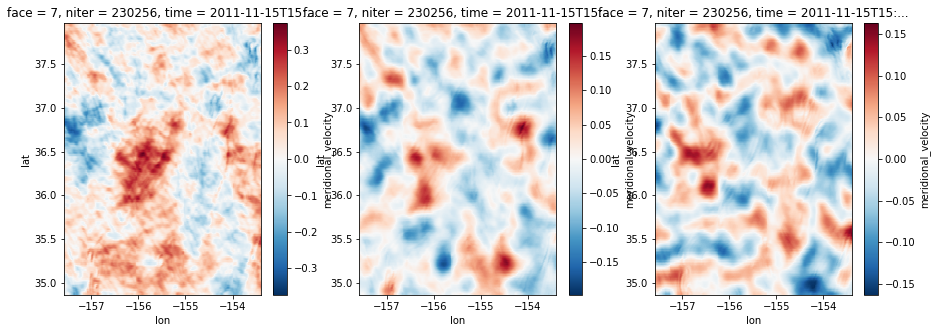

In [28]:
it = 15
v='meridional_velocity'
for dband in H.bandwidth:
    #for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    np.real(ds_hat[v+'_hat']).isel(time=it,T_window=1).sel(bandwidth=dband).plot(ax=ax[1],x='lon',y='lat')
    np.imag(ds_hat[v+'_hat']).isel(time=it,T_window=1).sel(bandwidth=dband).plot(ax=ax[2],x='lon',y='lat')
    dsp[v].isel(time=it).plot(ax=ax[0],x='lon',y='lat')#,x='lon',y='lat'

### Autocovariance

In [29]:
# Definition of the functions to compute the correlation
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'valid'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        _kwargs = {'mode': 'valid','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    #vv = vv[...,:]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1[Nr//2:], _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [30]:
# Wrapping function
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        #lags = np.arange(0,T//2+dt,dt)[:T//2*1/dt+1]
        C = xr.apply_ufunc(correlate_E, v1, v2,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [31]:
def correlate_nested(_ds,T_window, bandwidth,T, dt, mean='i'):
    lags = np.arange(0,T//2+dt,dt)[:T//2*24+1]
    _u = _ds.sel(T_window=T_window,bandwidth=bandwidth)
    Cvv = wrap_correlate(np.abs(_u), np.abs(_u),dt, lags=lags, roll=True,detrend=False, Nr=int(T/dt))#.persist()
    Cvv_mean = Cvv.mean(mean)#.compute()  
    #Cvv_mean.plot()
    return Cvv_mean

In [32]:
T = 30 #time window size (size of th segments)
dt = 1/24#float((ds.time[1]-ds.time[0]).values) # time step
binsize = 50 # binsize over which the correlation will be averaged
#_u = np.abs(test_autocorr.isel(i=slice(0,2),j=slice(0,2)))#ds.v.isel(x_rho=slice(0,2),y_rho=slice(0,2))
#lags, _ = wrap_correlate(_u, _u, dt, roll=True, Nr=int(T/dt),detrend=False) #initialization of the lags (used as input)

In [45]:
# Autocorrelation of v`
lags = np.arange(0,T//2+dt,dt)[:int(T//2*1/dt)+1]
_u = ds_hat['zonal_velocity_hat'].sel(T_window=20,bandwidth=0.1)
Cvv = wrap_correlate(np.abs(_u), np.abs(_u),dt,lags=lags,roll=True,detrend=False, Nr=int(T/dt)).persist()

<ipython-input-42-9daaa008877e>:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(correlate_E, v1, v2,


In [46]:
Cvv.mean('i').compute()

<xarray.DataArray 'correlation' (j: 101, lags: 361)>
array([[0.00244661, 0.00244669, 0.00244669, ..., 0.00196715, 0.00196674,
        0.00196632],
       [0.00242371, 0.0024238 , 0.0024238 , ..., 0.00194837, 0.00194807,
        0.00194776],
       [0.00239719, 0.00239729, 0.0023973 , ..., 0.00193297, 0.00193276,
        0.00193254],
       ...,
       [0.00382907, 0.00382958, 0.00383   , ..., 0.00333407, 0.00333358,
        0.00333302],
       [0.00381972, 0.00382024, 0.00382066, ..., 0.00332498, 0.00332441,
        0.00332377],
       [0.00381389, 0.00381441, 0.00381484, ..., 0.00331845, 0.00331784,
        0.00331715]])
Coordinates:
    face       int64 7
  * j          (j) int64 3000 3001 3002 3003 3004 ... 3096 3097 3098 3099 3100
    T_window   int64 20
    bandwidth  float64 0.1
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 14.92 14.96 15.0

In [47]:
Cvv_mean = Cvv.mean(['i','j']).compute()

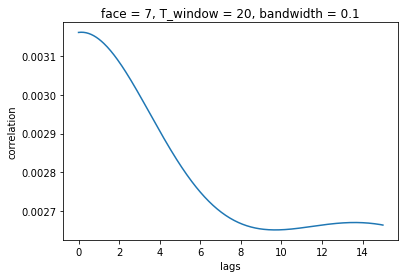

In [48]:
Cvv_mean.plot()

In [41]:
#ds_hat['zonal_velocity_hat'],T_w,dband,T,dt
def test_paralell(func,_ds):
    
    C = xr.combine_nested([[[correlate_nested(_ds,T_w,dband,T,dt) for T_w in T_window] for dband in bandwidths] for T in Tlag
                  ],concat_dim=['Tlag','bandwidth','T_window'])
    return C

In [56]:
ds_hat['zonal_velocity_hat'] = ds_hat['zonal_velocity_hat'].chunk({'T_window': -1})
ds_hat['zonal_velocity_hat'] = ds_hat['zonal_velocity_hat'].chunk({'bandwidth': -1})
xr.apply_ufunc(test_paralell, ds_hat['zonal_velocity_hat'],
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['T_window','bandwidth','i','j','time']],
                    output_core_dims=[['Tlag','bandwidth','T_window']],
                    output_sizes={'Tlag': len(Tlag),'bandwidth':len(bandwidths),'T_window':len(T_window)}).persist()#, kwargs=kwargs)

<ipython-input-56-7f693d42e012>:3: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  xr.apply_ufunc(test_paralell, ds_hat['zonal_velocity_hat'],
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/array/utils.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


<xarray.DataArray 'zonal_velocity' (Tlag: 1, bandwidth: 4, T_window: 3)>
dask.array<transpose, shape=(1, 4, 3), dtype=float64, chunksize=(1, 4, 3), chunktype=numpy.ndarray>
Coordinates:
    face       int64 7
  * T_window   (T_window) int64 10 20 30
  * bandwidth  (bandwidth) float64 0.1 0.2 0.3 0.4
Dimensions without coordinates: Tlag

In [33]:
Tlag=[20,30,40]
mean = 'i'
C = xr.combine_nested([[[correlate_nested(ds_hat['zonal_velocity_hat'],T_w,dband,T,dt,mean=mean) for T_w in T_window
                        ] for dband in bandwidths] for T in Tlag],concat_dim=['Tlag','bandwidth','T_window']).compute()

<ipython-input-30-9daaa008877e>:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(correlate_E, v1, v2,
<ipython-input-30-9daaa008877e>:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(correlate_E, v1, v2,
<ipython-input-30-9daaa008877e>:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(correlate_E, v1, v2,
<ipython-input-30-9daaa008877e>:10: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(correlate_E, v1, v2,
<ipython-input-30-9daaa008877e>:10: FutureWarning: ``output_sizes`` should be given in the `

In [34]:
C = C.assign_coords({'T_window':T_window,'bandwidth':bandwidths,'Tlag':Tlag})
C

<xarray.DataArray 'correlation' (T_window: 3, bandwidth: 4, Tlag: 3, j: 201, lags: 481)>
array([[[[[0.00390775, 0.00390788, 0.00390792, ...,        nan,
                  nan,        nan],
          [0.00389659, 0.00389673, 0.00389677, ...,        nan,
                  nan,        nan],
          [0.00390213, 0.00390227, 0.00390232, ...,        nan,
                  nan,        nan],
          ...,
          [0.00338765, 0.00338778, 0.00338782, ...,        nan,
                  nan,        nan],
          [0.00340149, 0.00340163, 0.00340169, ...,        nan,
                  nan,        nan],
          [0.00340945, 0.00340961, 0.00340969, ...,        nan,
                  nan,        nan]],

         [[0.00389738, 0.00389754, 0.00389759, ...,        nan,
                  nan,        nan],
          [0.00388538, 0.00388554, 0.00388561, ...,        nan,
                  nan,        nan],
          [0.00389061, 0.00389077, 0.00389084, ...,        nan,
                  nan,        nan],
...
          [0.00466759, 0.00466734, 0.00466568, ...,        nan,
                  nan,        nan],
          [0.00467526, 0.00467501, 0.00467333, ...,        nan,
                  nan,        nan],
          [0.00468405, 0.00468378, 0.00468208, ...,        nan,
                  nan,        nan]],

         [[0.00546703, 0.00546694, 0.00546521, ..., 0.00444611,
           0.00444422, 0.00444222],
          [0.00544046, 0.00544037, 0.00543864, ..., 0.00444877,
           0.0044468 , 0.00444473],
          [0.00543216, 0.00543206, 0.00543033, ..., 0.00446197,
           0.00446007, 0.00445806],
          ...,
          [0.00460016, 0.00459995, 0.00459833, ..., 0.00367669,
           0.0036758 , 0.00367485],
          [0.00460172, 0.00460151, 0.0045999 , ..., 0.00368993,
           0.00368929, 0.00368861],
          [0.00460705, 0.00460685, 0.00460522, ..., 0.00370428,
           0.00370386, 0.00370339]]]]])
Coordinates:
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 19.92 19.96 20.0
    face       int64 7
  * j          (j) int64 2900 2901 2902 2903 2904 ... 3096 3097 3098 3099 3100
  * T_window   (T_window) int64 10 20 30
  * bandwidth  (bandwidth) float64 0.1 0.2 0.3 0.4
  * Tlag       (Tlag) int64 20 30 40

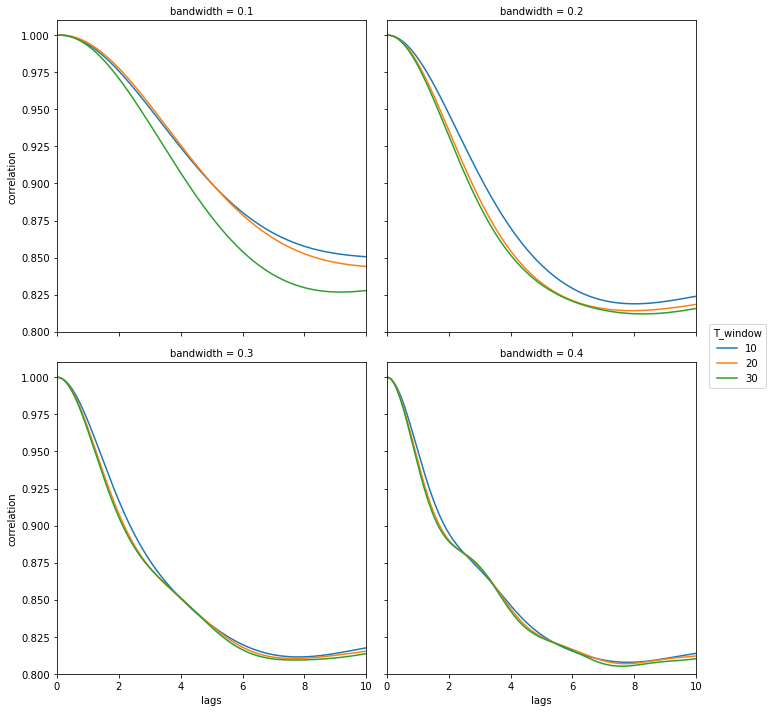

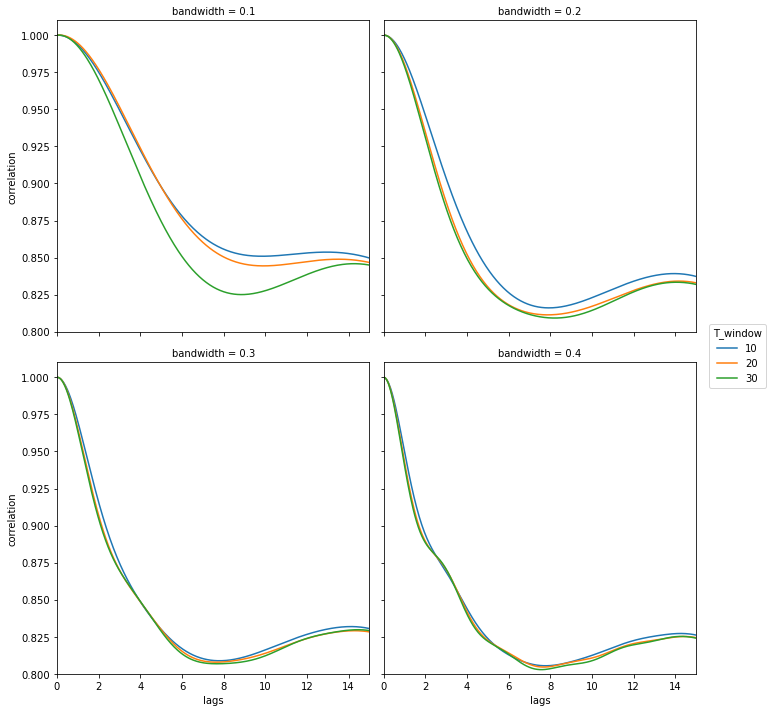

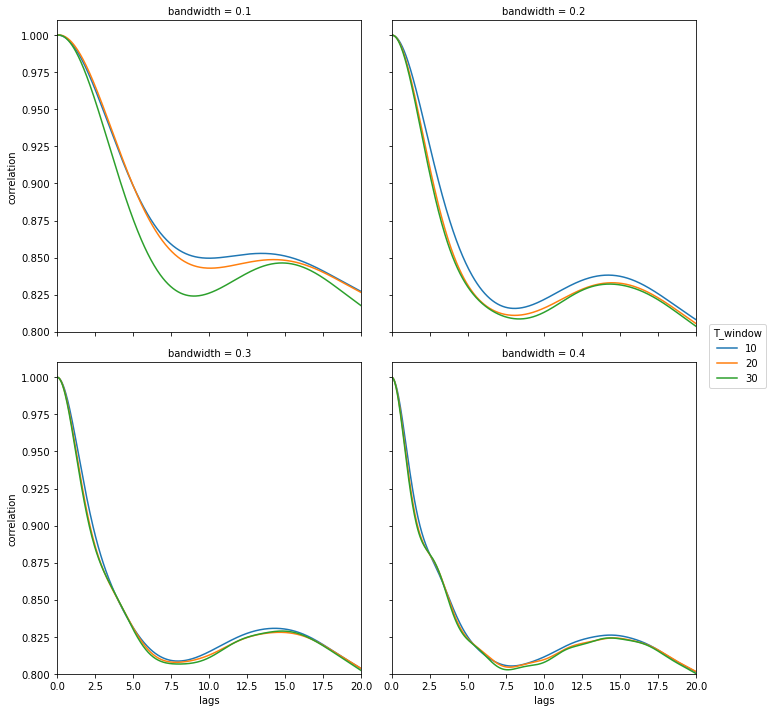

In [37]:
if mean==['i','j']:
    for T in Tlag:
        fig = (C/C.isel(lags=0)).sel(Tlag=T).plot(hue='T_window',col='bandwidth',col_wrap=2,xlim=(0,T//2),ylim=(0.8,1.01),figsize=(10,10))
else : 
    for T in Tlag:
        x = 'j'
        fig = (C.mean('j')/C.mean('j').isel(lags=0)).sel(Tlag=T).plot(hue='T_window',col='bandwidth',col_wrap=2,xlim=(0,T//2),ylim=(0.8,1.01),figsize=(10,10))

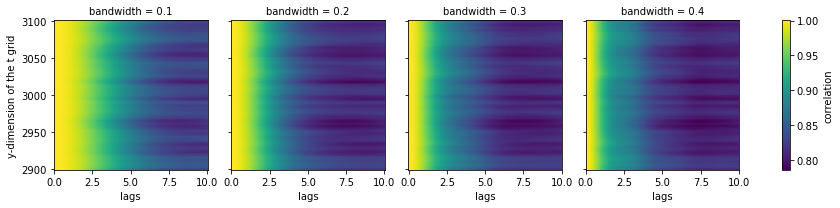

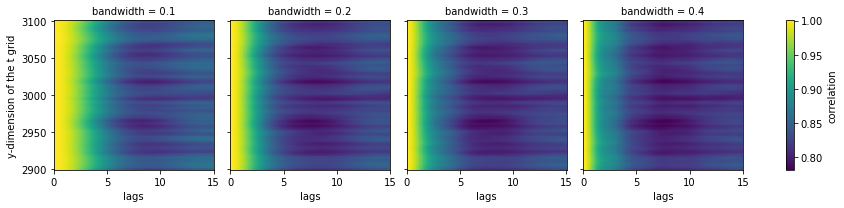

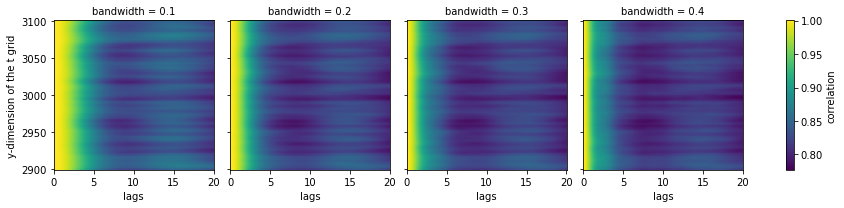

In [38]:
for T in Tlag:
    (C/C.isel(lags=0)).sel(Tlag=T,T_window=30).dropna('lags').plot(col='bandwidth')

### Lagrangian

In [11]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'time_mean'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

trajectory        lat         lon    z  zonal_velocity  \
time                                                                 
2011-11-15    39000000  57.835732 -178.867081  0.0             0.0   
2011-11-15    39000001  58.429878 -178.871994  0.0             0.0   
2011-11-15    39000002  59.018066 -178.879623  0.0             0.0   
2011-11-15    39000003  59.600288 -178.890015  0.0             0.0   
2011-11-15    39000004  60.176525 -178.903275  0.0             0.0   

            meridional_velocity  sea_level  temperature  salinity  Eta_interp  \
time                                                                            
2011-11-15                  0.0        0.0          0.0       0.0    0.060997   
2011-11-15                  0.0        0.0          0.0       0.0    0.075155   
2011-11-15                  0.0        0.0          0.0       0.0    0.169278   
2011-11-15                  0.0        0.0          0.0       0.0    0.242839   
2011-11-15                  0.0        0.0          0.0       0.0    0.222071   

            SSU_interp  SST_interp  SSV_interp  SSS_interp  
time                                                        
2011-11-15   -0.002461    4.279537   -0.006017   33.194778  
2011-11-15   -0.091730    4.326020    0.050204   33.139637  
2011-11-15   -0.203138    4.161501    0.209887   32.961617  
2011-11-15   -0.075768    3.679666    0.064889   32.712219  
2011-11-15   -0.006189    3.151162    0.057710   32.573410

In [12]:
lonmin,lonmax,latmin,latmax = dsp.lon.min().values,dsp.lon.max().values,dsp.lat.min().values,dsp.lat.max().values

In [13]:
# extract relevant trajectory indices
bbox=[lonmin,lonmax,latmin,latmax]
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
df_selected = df[df.trajectory.isin(traj)]

In [14]:
lon,lat = df_selected.lon.values.compute(),df_selected.lat.values.compute()
df_zon_vel = df_selected.zonal_velocity.values.compute()

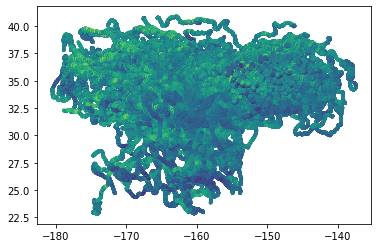

In [41]:
plt.scatter(lon,lat,c=df_zon_vel,s=6)

In [19]:
#df_selected[df_selected.index.values==dsp.time.values]
#df_selected[dsp.time.values[0]].index.values.compute()
#df_selected.loc[dsp.time.values[0]:dsp.time.values[-1]]#.index.values.compute()
i=traj[10:15]
dfi = df_selected[df_selected.trajectory.isin(i)]

In [20]:
dfi = dfi.compute()
dfi = dfi.drop_duplicates()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='lon', ylabel='lat'>

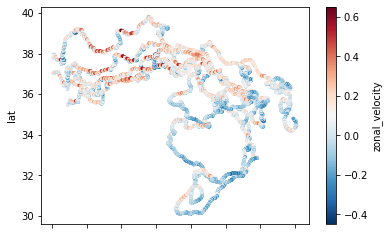

In [21]:
dfi.plot.scatter(x='lon',y='lat',c='zonal_velocity',s=5,cmap='RdBu_r')
#plt.scatter(dfi.lon.values.compute(),dfi.lat.values.compute(),s=6,c=time)

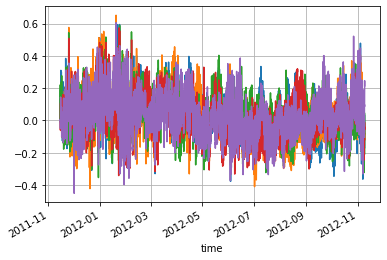

In [22]:
for ii in i:
    dfi[dfi.trajectory==ii].zonal_velocity.plot.line()
plt.grid()

In [23]:
def filt_L(v, h,columns, hilbert=False):
    vc = v.copy()
    for V in columns:
        vc[V+'_hat'] = convolve(v[V],h,hilbert=hilbert)
    
    #output_dtype = complex if hilbert else float
    #gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return vc#xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
            #        dask='parallelized', output_dtypes=[output_dtype],
            #       input_core_dims=[['time']],
            #        output_core_dims=[['time']],
            #       dask_gufunc_kwargs = gufunc_kwargs,
            #            )

In [54]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .4, "semidiurnal"

h = sp.generate_filter(omega, T=10, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

In [55]:
test_filter = dfi.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'])

In [56]:

test_filter = test_filter.drop(columns=['trajectory'])

In [57]:
test_filter.head()

lat         lon    z  zonal_velocity  \
trajectory time                                                              
37000592   2011-11-15 00:00:00  37.016800 -154.906250  0.0        0.000000   
           2011-11-15 01:00:00  37.021108 -154.899070  0.0        0.181373   
           2011-11-15 02:00:00  37.023981 -154.891777  0.0        0.180960   
           2011-11-15 03:00:00  37.025055 -154.884300  0.0        0.180174   
           2011-11-15 04:00:00  37.025118 -154.877453  0.0        0.189024   

                                meridional_velocity  sea_level  temperature  \
trajectory time                                                               
37000592   2011-11-15 00:00:00             0.000000   0.000000     0.000000   
           2011-11-15 01:00:00             0.142504   0.508808    18.713535   
           2011-11-15 02:00:00             0.121876   0.321305    18.663090   
           2011-11-15 03:00:00             0.054380   0.134983    18.663708   
           2011-11-15 04:00:00             0.010343  -0.018531    18.640547   

                                 salinity  Eta_interp  SSU_interp  SST_interp  \
trajectory time                                                                 
37000592   2011-11-15 00:00:00   0.000000    0.416156    0.065594   17.372723   
           2011-11-15 01:00:00  34.129665    0.416112    0.065764   17.372048   
           2011-11-15 02:00:00  34.114628    0.416012    0.066083   17.370509   
           2011-11-15 03:00:00  34.116161    0.415965    0.066314   17.369973   
           2011-11-15 04:00:00  34.113495    0.415904    0.066559   17.369205   

                                SSV_interp  SSS_interp  zonal_velocity_hat  \
trajectory time                                                              
37000592   2011-11-15 00:00:00   -0.008137   33.711727           -0.000213   
           2011-11-15 01:00:00   -0.007885   33.711417            0.033879   
           2011-11-15 02:00:00   -0.007306   33.710666            0.063129   
           2011-11-15 03:00:00   -0.006153   33.709541            0.079783   
           2011-11-15 04:00:00   -0.005120   33.708536            0.078547   

                                meridional_velocity_hat  
trajectory time                                          
37000592   2011-11-15 00:00:00                 0.052862  
           2011-11-15 01:00:00                 0.054436  
           2011-11-15 02:00:00                 0.042181  
           2011-11-15 03:00:00                 0.017651  
           2011-11-15 04:00:00                -0.014079

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

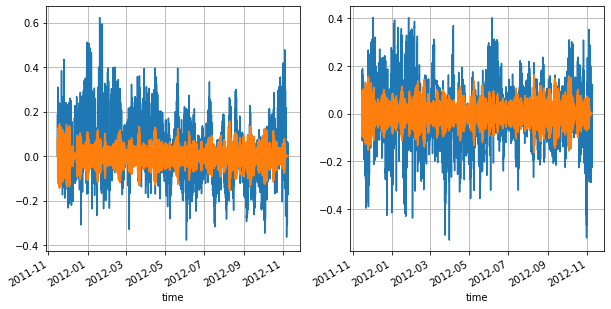

In [58]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    test_filter.loc[(37000592)][v].plot(ax=ax)
    test_filter.loc[(37000592)][v+'_hat'].plot(ax=ax)
    ax.grid()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

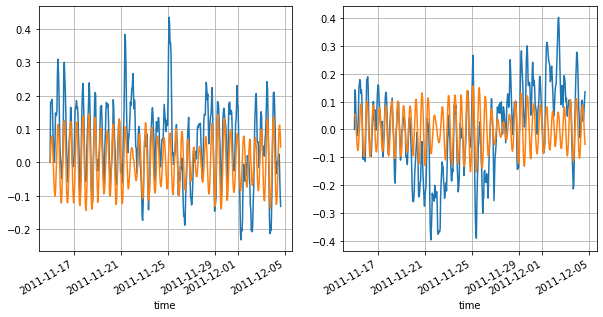

In [59]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    test_filter.loc[(37000592)][v][:20*24].plot(ax=ax)
    test_filter.loc[(37000592)][v+'_hat'][:20*24].plot(ax=ax)
    ax.grid()

In [60]:
test_filter['lon'] = (test_filter['lon']+180)%360 - 180
lon_bins = np.arange(test_filter.lon.min(),test_filter.lon.max(),1)
lat_bins = np.arange(test_filter.lat.min(),test_filter.lat.max(),1)
test_filter['lon_cut'] = pd.cut(test_filter['lon'],bins=lon_bins)#.map_partitions(pd.cut, lon_bins)
test_filter['lat_cut'] = pd.cut(test_filter['lat'],bins=lat_bins)#.map_partitions(pd.cut, lat_bins)

In [61]:
filter_mean = test_filter.groupby(['lon_cut','lat_cut']).mean()#.zonal_velocity.plot(x='lon_cut',y='lat_cut')
filter_mean = pa.add_geodata(filter_mean)

In [62]:
#means = pa.add_geodata(means)
#count['density'] = count['count']/count['area']

ds_mean = (filter_mean
     # .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

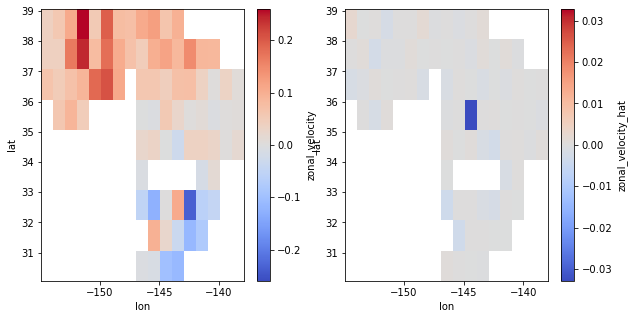

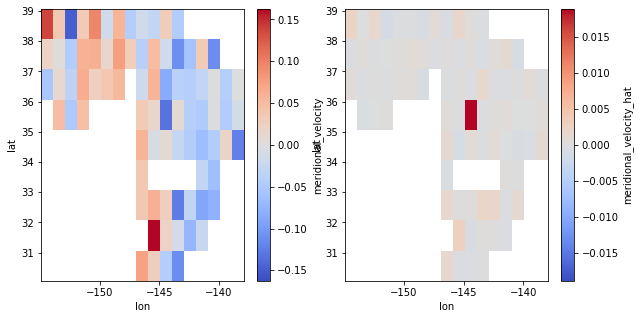

In [63]:
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ds_mean[v].plot(y='lat',ax=ax[0],cmap='coolwarm')
    ds_mean[v+'_hat'].plot(y='lat',ax=ax[1],cmap='coolwarm')

In [64]:
df_selected = df_selected.drop_duplicates()
df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'])

<ipython-input-64-712549c4162a>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'])


In [65]:
df_filtered = df_filtered.persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

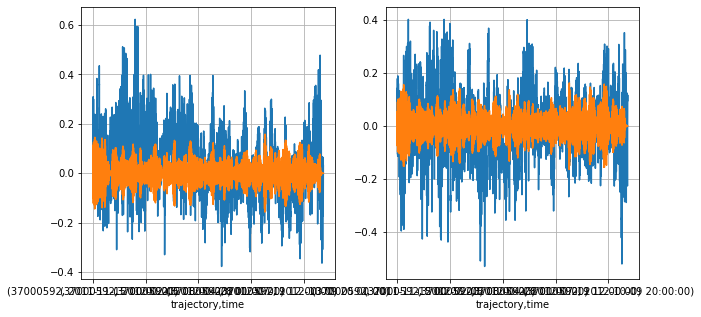

In [66]:
df_test = df_filtered.loc[(37000592)].compute()
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    df_test[v].plot(ax=ax)
    df_test[v+'_hat'].plot(ax=ax)
    ax.grid()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

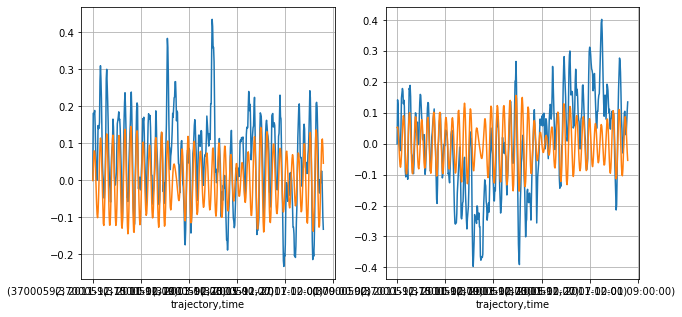

In [67]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    df_test[v][:20*24].plot(ax=ax)
    df_test[v+'_hat'][:20*24].plot(ax=ax)
    ax.grid()

In [68]:
df_filtered['lon'] = (df_filtered['lon']+180)%360 - 180
lon_bins = np.arange(df_filtered.lon.min().compute(),df_filtered.lon.max().compute(),0.5)
lat_bins = np.arange(df_filtered.lat.min().compute(),df_filtered.lat.max().compute(),0.5)
df_filtered['lon_cut'] = df_filtered['lon'].map_partitions(pd.cut, lon_bins)
df_filtered['lat_cut'] = df_filtered['lat'].map_partitions(pd.cut, lat_bins)

In [69]:
filter_mean = df_filtered.groupby(['lon_cut','lat_cut']).mean().compute()
filter_mean = pa.add_geodata(filter_mean)

In [70]:
ds_mean = (filter_mean
     # .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

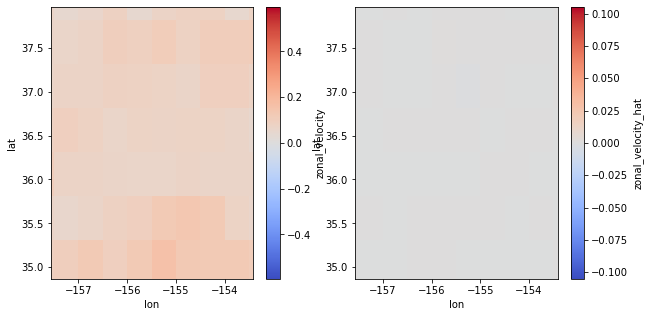

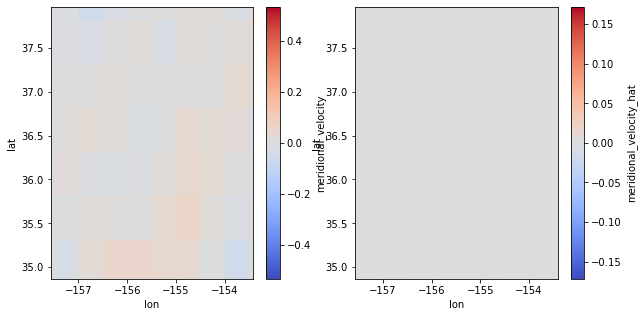

In [71]:
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ds_mean[v].plot(y='lat',ax=ax[0],cmap='coolwarm')
    ds_mean[v+'_hat'].plot(y='lat',ax=ax[1],cmap='coolwarm')
    ax[0].set_ylim(dsp.lat.min(),dsp.lat.max())
    ax[0].set_xlim(dsp.lon.min(),dsp.lon.max())
    ax[1].set_ylim(dsp.lat.min(),dsp.lat.max())
    ax[1].set_xlim(dsp.lon.min(),dsp.lon.max())

In [72]:
df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True).persist()

<ipython-input-72-ec29b881b5cf>:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True).persist()


In [73]:
for v in ['zonal_velocity','meridional_velocity']:
    df_filtered[v+'_hat'+'_real'] = df_filtered[v+'_hat'].apply(lambda x : np.real(x))
    df_filtered[v+'_hat'+'_imag'] = df_filtered[v+'_hat'].apply(lambda x : np.imag(x))
    df_filtered[v+'_hat'+'_abs'] = df_filtered[v+'_hat'].apply(lambda x : np.abs(x))
#df_filtered[['_real','_imag','_abs']] = df_filtered.drop(columns=['zonal_velocity','meridional_velocity','sea_level']
#                                                        ).groupby('trajectory').agg([np.real,np.imag,np.abs])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('zonal_velocity_hat', 'float64'))

  warnings.warn(meta_warning(meta))
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask/dataframe/core.py:3522: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

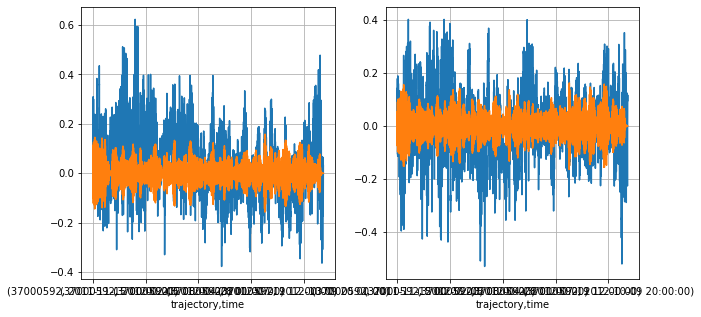

In [74]:
df_test = df_filtered.loc[(37000592)].compute()
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    df_test[v].plot(ax=ax)
    df_test[v+'_hat_real'].plot(ax=ax)
    ax.grid()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

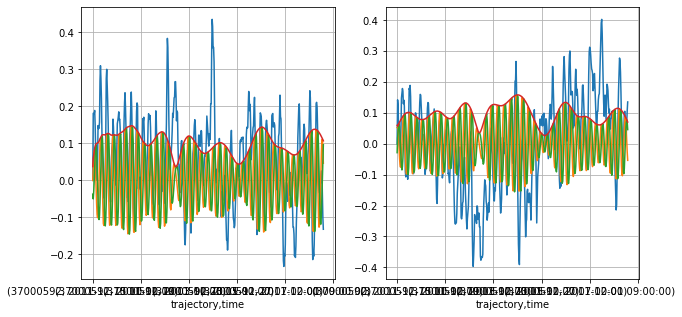

In [75]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    df_test[v][:20*24].plot(ax=ax)
    df_test[v+'_hat_real'][:20*24].plot(ax=ax)
    df_test[v+'_hat_imag'][:20*24].plot(ax=ax)
    df_test[v+'_hat_abs'][:20*24].plot(ax=ax)
    ax.grid()

### Sensitivity to filter parameters

In [76]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .2, "semidiurnal"
T_window,bandwidths = [10,20,30],[0.1,0.2,0.3,0.4]

In [77]:
H = xr.combine_nested([[xr.DataArray(sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None),
             dims=['time'],coords={'time':np.arange(0,sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None).size)*dt}) for T in T_window
                       ] for dband in bandwidths],concat_dim=['bandwidth','T_window'])
                     # coords={'time':np.arange(0,sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None).size)*dt,'T_window':T_window,'bandwidth':bandwidths})

H = H.assign_coords({'T_window':T_window,'bandwidth':bandwidths})
H

<xarray.DataArray (T_window: 3, bandwidth: 4, time: 720)>
array([[[-4.79577095e-06, -1.94207612e-05, -3.28593800e-05, ...,
                     nan,             nan,             nan],
        [ 8.04766936e-06,  3.25671830e-05,  5.50271995e-05, ...,
                     nan,             nan,             nan],
        [-1.20939217e-05, -4.88855777e-05, -8.24106337e-05, ...,
                     nan,             nan,             nan],
        [ 1.61943560e-05,  6.53554406e-05,  1.09821756e-04, ...,
                     nan,             nan,             nan]],

       [[ 5.61926911e-07, -2.48335914e-06, -1.01159979e-05, ...,
                     nan,             nan,             nan],
        [ 1.13105376e-06, -4.99511167e-06, -2.03197566e-05, ...,
                     nan,             nan,             nan],
        [ 1.69582901e-06, -7.48079141e-06, -3.03617031e-05, ...,
                     nan,             nan,             nan],
        [ 2.25971183e-06, -9.95228970e-06, -4.02629625e-05, ...,
                     nan,             nan,             nan]],

       [[ 1.73690142e-06,  3.63845117e-06,  1.90621384e-06, ...,
          1.90621384e-06,  3.63845117e-06,  1.73690142e-06],
        [-3.48786449e-06, -7.30135118e-06, -3.81999158e-06, ...,
         -3.81999158e-06, -7.30135118e-06, -3.48786449e-06],
        [ 5.21062466e-06,  1.08952439e-05,  5.68723806e-06, ...,
          5.68723806e-06,  1.08952439e-05,  5.21062466e-06],
        [-6.96657159e-06, -1.45435602e-05, -7.56727158e-06, ...,
         -7.56727158e-06, -1.45435602e-05, -6.96657159e-06]]])
Coordinates:
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 29.88 29.92 29.96
  * T_window   (T_window) int64 10 20 30
  * bandwidth  (bandwidth) float64 0.1 0.2 0.3 0.4

In [80]:
df_selected = df_selected.drop(columns=[v+'_interp' for v in ['SST','SSS','SSU','SSV','Eta']])
df_selected = df_selected.drop(columns=['sea_level','temperature','salinity','z'])    
df_selected = df_selected.persist()
#df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'],hilbert=True).persist()

In [104]:
H.sel(T_window=20,bandwidth=0.1).dropna('time').to_series().index#.to_dataset(name='h').to_dataframe()
#.to_dataframe(name='h')

Float64Index([                 0.0, 0.041666666666666664,  0.08333333333333333,
                             0.125,  0.16666666666666666,  0.20833333333333331,
                              0.25,  0.29166666666666663,   0.3333333333333333,
                             0.375,
              ...
                19.583333333333332,               19.625,   19.666666666666664,
                19.708333333333332,                19.75,   19.791666666666664,
                19.833333333333332,               19.875,   19.916666666666664,
                19.958333333333332],
             dtype='float64', name='time', length=480)

In [135]:
H.values.shape

(3, 4, 720)

In [142]:
def filt_Lcombined(v, h,columns, Tw, dband,hilbert=False):
    vc = v.copy()
    for i,Tw in enumerate(T_window):
        for j,dband in enumerate(bandwidths):
            H = h[i,j,:]#.sel(T_window=Tw,bandwidth=dband).dropna('time').values
            for V in columns:
                vc[V+'_hat'+str(Tw)+'_'+str(dband)] = convolve(v[V],H,hilbert=hilbert)
    
    #output_dtype = complex if hilbert else float
    #gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return vc


In [147]:
#ds_selected = xr.Dataset.from_dataframe(df_selected)
#xr.Dataset.from_dataframe(df_selected.drop(columns='trajectory').reset_index().set_index(['trajectory','time']))
T_window = [20]
bandwidths = [0.1,0.2]
H = xr.combine_nested([[xr.DataArray(sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None),
             dims=['time'],coords={'time':np.arange(0,sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None).size)*dt}) for T in T_window
                       ] for dband in bandwidths],concat_dim=['bandwidth','T_window'])
                     # coords={'time':np.arange(0,sp.generate_filter(omega, T=T, dt=dt, bandwidth=dband, normalized_bandwidth=None).size)*dt,'T_window':T_window,'bandwidth':bandwidths})

H = H.assign_coords({'T_window':T_window,'bandwidth':bandwidths})


In [145]:
#test_sensitivity = [[df_selected.groupby('trajectory').apply(filt_L,H.sel(T_window=Tw,bandwidth=dband).dropna('time').values
#                                          ,['zonal_velocity','meridional_velocity'],hilbert=True
#                                         ).persist() for Tw in T_window] for dband in bandwidths]
test_sensitivity = df_selected.groupby('trajectory').apply(filt_Lcombined,H.values,['zonal_velocity','meridional_velocity'],T_window,bandwidths,hilbert=True).persist()

<ipython-input-145-98db0ce9770f>:4: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  test_sensitivity = df_selected.groupby('trajectory').apply(filt_Lcombined,H.values,['zonal_velocity','meridional_velocity'],T_window,bandwidths,hilbert=True).persist()


In [146]:
test_sensitivity
for v in ['zonal_velocity','meridional_velocity']:
    df_filtered[v+'_hat'+'_real'] = df_filtered[v+'_hat'].apply(lambda x : np.real(x))
    df_filtered[v+'_hat'+'_imag'] = df_filtered[v+'_hat'].apply(lambda x : np.imag(x))
    df_filtered[v+'_hat'+'_abs'] = df_filtered[v+'_hat'].apply(lambda x : np.abs(x))

Dask DataFrame Structure:
              trajectory      lat      lon zonal_velocity meridional_velocity zonal_velocity_hat20_0.1 meridional_velocity_hat20_0.1 zonal_velocity_hat20_0.2 meridional_velocity_hat20_0.2
npartitions=1                                                                                                                                                                              
                   int32  float64  float64        float64             float32               complex128                    complex128               complex128                    complex128
                     ...      ...      ...            ...                 ...                      ...                           ...                      ...                           ...
Dask Name: filt_Lcombined, 1 tasks

In [149]:
ds_selected =xr.Dataset.from_dataframe(df_selected)

In [158]:
ds_selected.groupby('trajectory').get_group(215256)#apply(filt,H.sel(T_window=20,bandwidth=0.1).dropna(dim='time'),hilbert=True)

AttributeError: 'DatasetGroupBy' object has no attribute 'get_group'

### Autocorrelations

In [ ]:
# Wrapping function to apply the correlation to each drifter
def wrap_correlate(DS,columns,T,dt,L,binsize,detrend=True):
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
    df_chunked = DS.groupby(DS.index).apply(cdr.time_window_processing,
                                            cdr.correlate, columns, T, int(T/dt),L, detrend=detrend,dt=dt
                                           ).persist()
                                         #   meta=('x', 'f8'))
    # the dataframe partitions has a multi-index: id and window central time (unknow name for now)
    # we first transform the index corresponding to time into a regular column.
    df_chunked = (
                  df_chunked.map_partitions(
                      lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                           )
                  )
    # bin along y and sum
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    return df_chunked

In [159]:
cluster.close()